In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from sklearn.linear_model import LinearRegression as LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor



This notebook is a preliminary attempt at fitting models to predict overall sink percentage. Subsuquent notebooks refine the models

In [3]:
#DataFrames
sc = pd.read_csv('Excel_Files/Complete_Data/SC_Data.csv')
ob = pd.read_csv('Excel_Files/Complete_Data/OB_Data.csv')
hx = pd.read_csv('Excel_Files/Complete_Data/HX_Data.csv')

In [4]:
#Calculate Sink Rates
def Divide(a,b):
    if b == 0:
        return np.nan
    return a / b

sc['Overall Sink Percentage'] = sc.apply(lambda row: Divide(row['Number of Ships Sunk'], row['Number of Ships'], ), axis=1)
sc['Escort Sink Percentage'] = sc.apply(lambda row: Divide(row['Number of Escorts Sunk'], row['Number of Escort Ships']), axis=1)
sc['Straggler Sink Percentage'] = sc.apply(lambda row: Divide(row['Number of Stragglers Sunk'], row['Number of Stragglers'],), axis=1)
sc['Overall Sink Percentage'] = sc['Overall Sink Percentage'] * 100
sc['Escort Sink Percentage'] = sc['Escort Sink Percentage'] * 100
sc['Straggler Sink Percentage'] = sc['Straggler Sink Percentage'] * 100
sc['Depart_Date'] = pd.to_datetime(sc['Depart_Date'], errors='coerce')
sc = sc.fillna(0)

ob['Overall Sink Percentage'] = ob.apply(lambda row: Divide(row['Number of Ships Sunk'], row['Number of Ships'], ), axis=1)
ob['Escort Sink Percentage'] = ob.apply(lambda row: Divide(row['Number of Escorts Sunk'], row['Number of Escort Ships']), axis=1)
ob['Straggler Sink Percentage'] = ob.apply(lambda row: Divide(row['Number of Stragglers Sunk'], row['Number of Stragglers'],), axis=1)
ob['Overall Sink Percentage'] = ob['Overall Sink Percentage'] * 100
ob['Escort Sink Percentage'] = ob['Escort Sink Percentage'] * 100
ob['Straggler Sink Percentage'] = ob['Straggler Sink Percentage'] * 100
ob['Depart_Date'] = pd.to_datetime(ob['Depart_Date'], errors='coerce')
ob = ob.fillna(0)

hx['Overall Sink Percentage'] = hx.apply(lambda row: Divide(row['Number of Ships Sunk'], row['Number of Ships'], ), axis=1)
hx['Escort Sink Percentage'] = hx.apply(lambda row: Divide(row['Number of Escorts Sunk'], row['Number of Escort Ships']), axis=1)
hx['Straggler Sink Percentage'] = hx.apply(lambda row: Divide(row['Number of Stragglers Sunk'], row['Number of Stragglers'],), axis=1)
hx['Overall Sink Percentage'] = hx['Overall Sink Percentage'] * 100
hx['Escort Sink Percentage'] = hx['Escort Sink Percentage'] * 100
hx['Straggler Sink Percentage'] = hx['Straggler Sink Percentage'] * 100
hx['Depart_Date'] = pd.to_datetime(hx['Depart_Date'], errors='coerce')
hx = hx.fillna(0)

In [5]:
#Combine DataFrames
sc = sc.rename(columns={'SC Convoy Number': 'Convoy Number', 'Arrive_Date': 'Arrival/Dispersal Date'})
ob = ob.rename(columns={'OB Convoy Number': 'Convoy Number', 'Dispersed_Date': 'Arrival/Dispersal Date'})
hx = hx.rename(columns={'HX Convoy Number': 'Convoy Number', 'Arrive_Date': 'Arrival/Dispersal Date'})
frames = [sc, ob, hx]
df = pd.concat(frames, ignore_index=True)
df = df.sort_values(by='Depart_Date')
df.head(-10)
#df.to_csv('SC-OB-HX-Data.csv')


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Depart_Date,Arrival/Dispersal Date,Overall Sink Percentage,Escort Sink Percentage,Straggler Sink Percentage
177,OB.1,5,2,0,0,0,0,22877,0,1939-09-07,1939-09-10,0.0,0.0,0.0
178,OB.2,5,2,0,0,0,0,22967,0,1939-09-09,1939-09-14,0.0,0.0,0.0
179,OB.3,7,4,0,0,0,0,21293,0,1939-09-11,1939-09-16,0.0,0.0,0.0
180,OB.4,12,2,0,0,0,0,77587,0,1939-09-13,1939-09-16,0.0,0.0,0.0
181,OB.5,20,3,0,0,0,0,98187,0,1939-09-16,1939-09-19,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,HX.349,90,32,0,0,0,0,445660,0,1945-04-08,1945-04-23,0.0,0.0,0.0
875,HX.350,117,33,0,0,0,0,654111,0,1945-04-13,1945-04-28,0.0,0.0,0.0
876,HX.351,92,38,0,0,0,0,414520,0,1945-04-18,1945-05-03,0.0,0.0,0.0
172,SC.173,29,10,0,0,0,0,103615,0,1945-04-18,1945-05-04,0.0,0.0,0.0


In [6]:
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Number of Escorts Sunk', 'Number of Stragglers Sunk',\
'Total Tons of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Escort Sink Percentage', 'Straggler Sink Percentage'])

In [7]:
df.describe()

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage
count,884.000000,884.000000,884.000000,8.840000e+02,884.000000
mean,51.090498,11.916290,0.449095,2.361160e+05,1.266582
std,26.938392,8.813649,1.501494,1.473992e+05,3.624235
min,2.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,32.000000,4.000000,0.000000,1.335320e+05,0.000000
50%,48.000000,11.000000,0.000000,2.004740e+05,0.000000
75%,67.000000,18.000000,0.000000,3.000672e+05,0.000000
max,191.000000,47.000000,22.000000,1.054593e+06,46.511628


In [8]:
#Scale Data
SS = SS()
X_scaled = SS.fit_transform(df.drop(columns ='Overall Sink Percentage'))

In [9]:
#Preform PCA 
pca = PCA()
PCA_X= pca.fit_transform(X_scaled)
PCA_X_df = pd.DataFrame(PCA_X[:,:2], columns = ['PC1','PC2'])
PCA_X_df['Overall Sink Percentage'] = df['Overall Sink Percentage']

In [10]:
print(pca.explained_variance_ratio_)

[0.66433958 0.25051169 0.0753961  0.00975263]


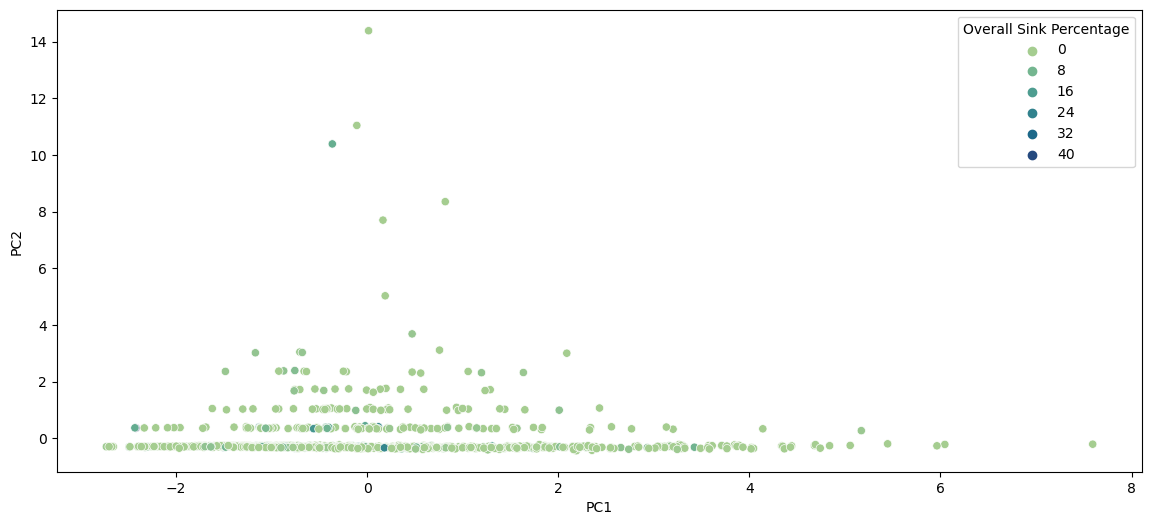

In [11]:
#Plot PCA
plt.figure(figsize=(14, 6))
sns.scatterplot(data=PCA_X_df, x='PC1', y='PC2', hue='Overall Sink Percentage', palette='crest')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

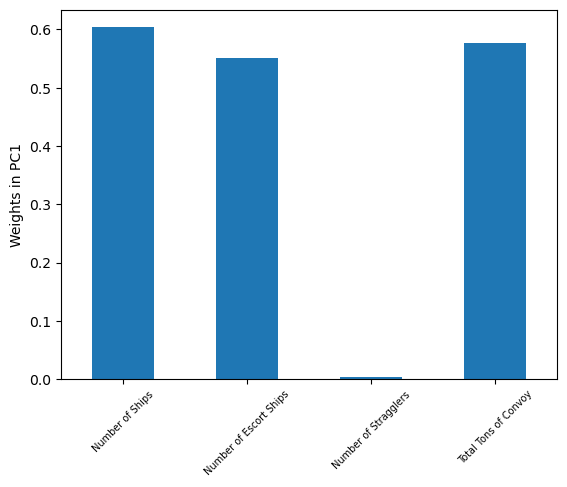

0    0.603696
1    0.551012
2    0.004266
3    0.576124
dtype: float64


In [12]:
pca_component_1 = pd.Series(pca.components_[0])
pca_component_1.plot.bar()
labels = df.drop(columns='Overall Sink Percentage').columns
plt.xticks(range(len(labels)), labels, fontsize=7, rotation=45)
plt.ylabel('Weights in PC1')
plt.show()
print(pca_component_1)

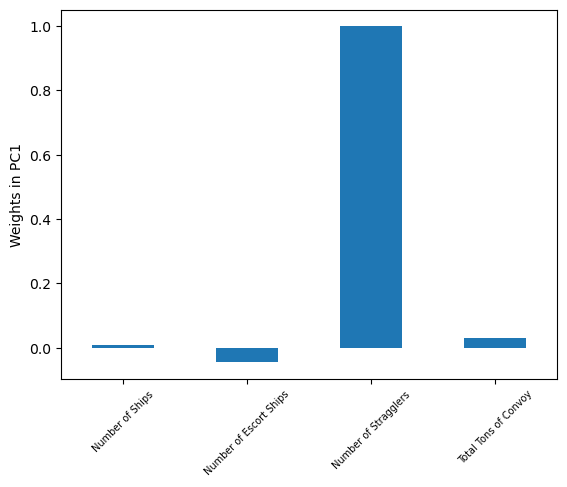

0    0.007212
1   -0.045802
2    0.998508
3    0.028855
dtype: float64


In [13]:
pca_component_2 = pd.Series(pca.components_[1])
pca_component_2.plot.bar()
labels = df.drop(columns='Overall Sink Percentage').columns
plt.xticks(range(len(labels)), labels, fontsize=7, rotation=45)
plt.ylabel('Weights in PC1')
plt.show()
print(pca_component_2)

Prediction Models

In [14]:
#Linear Regression Model
y = df['Overall Sink Percentage'].values
X = np.array(df.drop(columns='Overall Sink Percentage'))
feature_names = df.drop(columns='Overall Sink Percentage').columns
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, random_state=1945)
X_train_scaled = SS.fit_transform(Xtrain)
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, ytrain)
y_predict = LR_model.predict(SS.transform(Xtest))
print('Linear Regression Train Score (R\u00b2):', LR_model.score(X_train_scaled, ytrain))
print('Linear Regression Coefficients:', LR_model.coef_)
print('Linear Regression Intercepts:', LR_model.intercept_)
print('Linear Regression Test Score (R\u00b2):', LR_model.score(SS.transform(Xtest), ytest))

Linear Regression Train Score (R²): 0.060307398658077105
Linear Regression Coefficients: [ 2.37996622 -0.61183675  0.63591562 -2.07718457]
Linear Regression Intercepts: 1.267031842179273
Linear Regression Test Score (R²): 0.1667004179679712


The low train score and high negative test score indicate this model fits the data very poorly. 

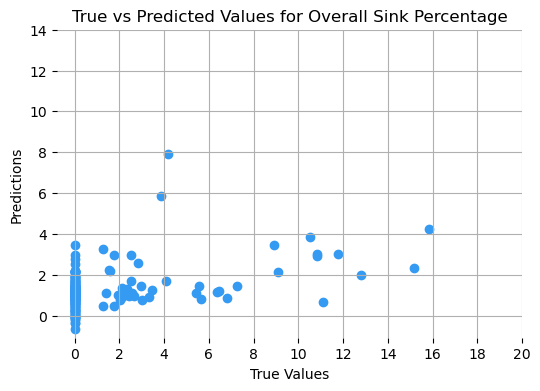

In [15]:
plt.figure(figsize=(6,4))
plt.scatter(ytest, y_predict, color='#359af2')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xticks(np.arange(0, 22, 2))
plt.yticks(np.arange(0, 16, 2))
plt.title('True vs Predicted Values for Overall Sink Percentage')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid()
plt.show()

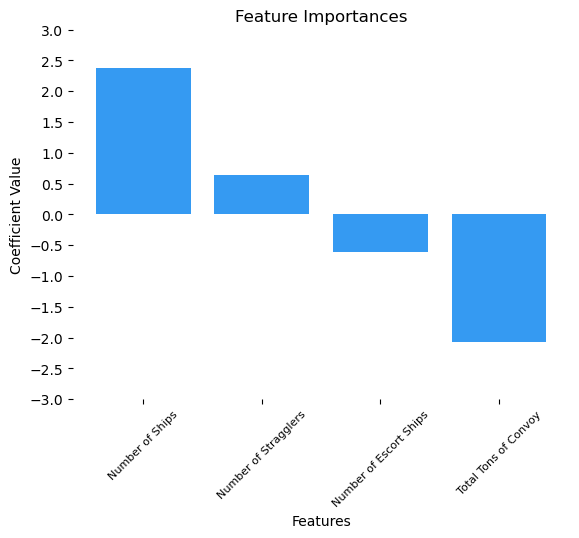

In [16]:
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': LR_model.coef_})
coef_df = coef_df.sort_values('Coefficient', ascending=False)
plt.bar(coef_df['Feature'], coef_df['Coefficient'], color='#359af2')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.yticks(np.arange(-3, 3.5, 0.5))
plt.title('Feature Importances')
plt.xticks(fontsize= 8, rotation=45)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

The model is unable to fit the data well. Examining cases where at least one ship was sunk might give a better fitting model. 

In [61]:
#Examining Cases Where at Least One Ship was Sunk
df_2 = df[df['Overall Sink Percentage'] != 0]
df_2.head()
#df_2.to_csv('Sink_Cases_Only.csv')

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage
193,18,2,1,83452,5.555556
194,12,2,0,66074,8.333333
525,23,7,0,90517,8.695652
201,21,2,0,129835,4.761905
222,9,2,0,49474,11.111111


In [18]:
#Drop irrelevant features (Already dropped in df)
#df_2 = df_2.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Number of Escorts Sunk', 'Number of Stragglers Sunk',\
        #'Total Tons of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Escort Sink Percentage', 'Straggler Sink Percentage'])

In [19]:
df_2.describe()


,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,52.770053,11.978610,1.021390,225619.684492,5.987479
std,19.159645,6.983819,1.863507,102887.574786,5.825640
min,9.000000,1.000000,0.000000,49474.000000,0.990099
25%,40.500000,7.000000,0.000000,150775.500000,2.127660
50%,49.000000,11.000000,0.000000,208323.000000,3.846154
75%,63.500000,17.000000,1.000000,266905.500000,8.077843
max,124.000000,34.000000,16.000000,712910.000000,46.511628


In [20]:
#Linear Regression Model (Only Cases Where at Least One Ship was Sunk)
y = df_2['Overall Sink Percentage'].values
X = np.array(df_2.drop(columns='Overall Sink Percentage'))
feature_names = df_2.drop(columns='Overall Sink Percentage').columns
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, random_state=1945)
X_train_scaled = SS.fit_transform(Xtrain)
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, ytrain)
y_predict = LR_model.predict(SS.transform(Xtest))
print('Linear Regression Train Score (R\u00b2):', LR_model.score(X_train_scaled, ytrain))
print('Linear Regression Coefficients:', LR_model.coef_)
print('Linear Regression Intercepts:', LR_model.intercept_)
print('Linear Regression Test Score (R\u00b2):', LR_model.score(SS.transform(Xtest), ytest))

Linear Regression Train Score (R²): 0.06489217497133892
Linear Regression Coefficients: [ 1.98938121 -0.24421851  0.57806342 -2.87197775]
Linear Regression Intercepts: 6.4263562302066015
Linear Regression Test Score (R²): -0.340627967684731


In [21]:
#Linear Regression Model (Only Cases Where at Least One Ship was Sunk) (Different Random State)
y = df_2['Overall Sink Percentage'].values
X = np.array(df_2.drop(columns='Overall Sink Percentage'))
feature_names = df_2.drop(columns='Overall Sink Percentage').columns
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, random_state=1944)
X_train_scaled = SS.fit_transform(Xtrain)
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, ytrain)
y_predict = LR_model.predict(SS.transform(Xtest))
print('Linear Regression Train Score (R\u00b2):', LR_model.score(X_train_scaled, ytrain))
print('Linear Regression Coefficients:', LR_model.coef_)
print('Linear Regression Intercepts:', LR_model.intercept_)
print('Linear Regression Test Score (R\u00b2):', LR_model.score(SS.transform(Xtest), ytest))

Linear Regression Train Score (R²): 0.05979735166048261
Linear Regression Coefficients: [ 1.07004777 -0.1089093   0.61191663 -2.22775133]
Linear Regression Intercepts: 6.164283021691073
Linear Regression Test Score (R²): 0.031628626753056444


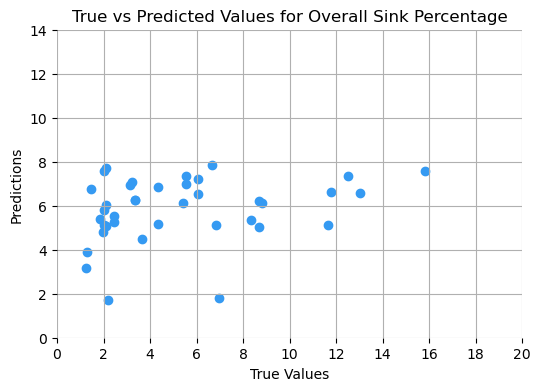

In [22]:
plt.figure(figsize=(6,4))
plt.scatter(ytest, y_predict, color='#359af2')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xticks(np.arange(0, 22, 2))
plt.yticks(np.arange(0, 16, 2))
plt.title('True vs Predicted Values for Overall Sink Percentage')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid()
plt.show()

The random state of the train test split for the linear regression model results in train and test scores that are wildley inconsistent across the different random states. K-Fold Cross-Validation will be implemeneted to fix this. 

In [23]:
#K-Fold Cross-Validation
def K_Fold(model, X, y, K, scaler=None, random_state=1945):
    kf = KFold(n_splits=K, random_state=random_state, shuffle=True)
    train_scores = []
    test_scores = []
    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain]
        Xtest = X[idxTest]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler is not None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
        model.fit(Xtrain, ytrain)
        train_scores.append(model.score(Xtrain, ytrain))
        test_scores.append(model.score(Xtest, ytest))
    return train_scores, test_scores

In [24]:
#Converting X & y to correct format for use in K-Fold Cross-Validation
X = np.array(df_2.drop(columns='Overall Sink Percentage'))
y = df_2['Overall Sink Percentage'].values

In [25]:
#K-Fold Cross-Validation Linear Regression
train_scores, test_scores = K_Fold(LR_model, X, y, 10, SS)
print('K_Fold Linear Regression Train Score (R\u00b2):  ', np.mean(train_scores))
print('K_Fold Linear Regression Testing Score (R\u00b2):', np.mean(test_scores))

K_Fold Linear Regression Train Score (R²):   0.06456963768865596
K_Fold Linear Regression Testing Score (R²): -0.11782062329795433


Attempting Ridge Regression for a better fitting model:

In [26]:
#Find Optimal Alpha Value
a_range = np.linspace(0,300,151) 
avg_tr_score = []
avg_te_score = []
for a in a_range:
    rid_reg = Ridge(alpha=a, max_iter=10000)
    train_scores, test_scores = K_Fold(rid_reg, X, y, 10, SS)
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
#print(a_range)

In [27]:
#Find Optimal Alpha Value
alpha_max = a_range[np.argmax(avg_te_score)]
print('Optimal \u03B1 Value:', alpha_max)

Optimal α Value: 254.0


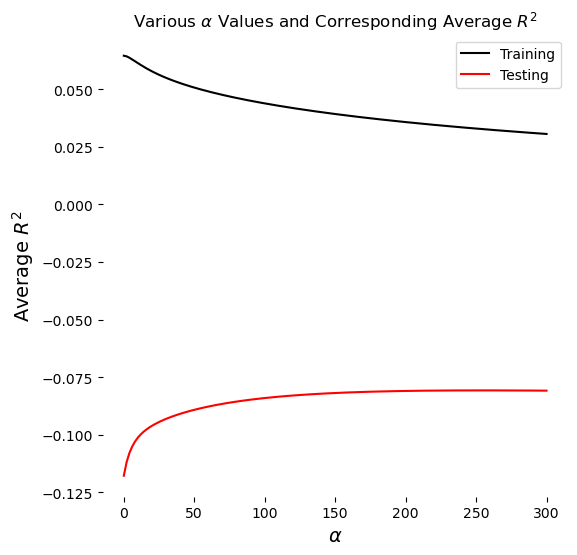

In [28]:
#Plotting different alpha and respectice train & test scores
plt.figure(figsize=(6,6))
plt.plot(a_range, avg_tr_score, color='k', label='Training')
plt.plot(a_range, avg_te_score, color='r', label='Testing')
plt.title('Various $\\alpha$ Values and Corresponding Average $R^2$')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Average $R^2$', fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()
plt.show()

In [29]:
rid_reg = Ridge(alpha=98, max_iter=10000) #Using optimal alpha value
train_scores, test_scores = K_Fold(rid_reg, X, y, 10, SS)
print('K_Fold Ridge Regression Train Score (R\u00b2):', np.mean(train_scores))
print('K_Fold Ridge Regression Test Score (R\u00b2):',np.mean(test_scores))

K_Fold Ridge Regression Train Score (R²): 0.04408764793941331
K_Fold Ridge Regression Test Score (R²): -0.0842159310729093


Ridge Regression does not fit the model any better than Linear Regression. A new approach must be taken to get a prediction model. Duration of the convoy will be introduced as a new feature. Additionally, models capturing non-linear relationships will be tried.


In [30]:
df_3 = pd.read_csv('Excel_Files/Complete_Data/Sink_Cases_Only.csv')
df_3 = df_3.drop(columns=['Unnamed: 0'])
df_3['Depart_Date'] = pd.to_datetime(df_3['Depart_Date'])
df_3['Arrival/Dispersal Date'] = pd.to_datetime(df_3['Arrival/Dispersal Date'])
df_3['Time At Sea (Days)'] = (df_3['Arrival/Dispersal Date'] - df_3['Depart_Date']).dt.days
df_3.describe()

,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Overall Sink Percentage,Escort Sink Percentage,Straggler Sink Percentage,Time At Sea (Days)
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,52.770053,11.978610,1.021390,3.026738,0.101604,0.593583,225619.684492,16732.144385,5.987479,0.739089,35.762032,11.770053
std,19.159645,6.983819,1.863507,3.188408,0.352178,0.877166,102887.574786,17402.838115,5.825640,2.638490,45.738687,5.920219
min,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,49474.000000,925.000000,0.990099,0.000000,0.000000,2.000000
25%,40.500000,7.000000,0.000000,1.000000,0.000000,0.000000,150775.500000,6021.500000,2.127660,0.000000,0.000000,5.000000
50%,49.000000,11.000000,0.000000,2.000000,0.000000,0.000000,208323.000000,9034.000000,3.846154,0.000000,0.000000,14.000000
75%,63.500000,17.000000,1.000000,4.000000,0.000000,1.000000,266905.500000,19386.500000,8.077843,0.000000,100.000000,16.000000
max,124.000000,34.000000,16.000000,20.000000,3.000000,5.000000,712910.000000,93502.000000,46.511628,16.666667,100.000000,25.000000


In [54]:
X = df_3.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', \
                       'Total Tons of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Overall Sink Percentage', \
                        'Escort Sink Percentage', 'Straggler Sink Percentage']) #Drop all irrelevant features
y = df_3['Overall Sink Percentage'] #Target for prediction models
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1945) 
#(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [55]:
X.describe()

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Time At Sea (Days)
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,52.770053,11.978610,1.021390,225619.684492,11.770053
std,19.159645,6.983819,1.863507,102887.574786,5.920219
min,9.000000,1.000000,0.000000,49474.000000,2.000000
25%,40.500000,7.000000,0.000000,150775.500000,5.000000
50%,49.000000,11.000000,0.000000,208323.000000,14.000000
75%,63.500000,17.000000,1.000000,266905.500000,16.000000
max,124.000000,34.000000,16.000000,712910.000000,25.000000


In [60]:
#K Nearest Neighbors Model
knn = KNeighborsRegressor(n_neighbors=5)
X_train_scaled = SS.fit_transform(X_train)
knn.fit(X_train_scaled, y_train)
y_predict_knn = knn.predict(SS.transform(X_test))
mse_knn = mean_squared_error(y_test, y_predict_knn)
r2_knn = r2_score(y_test, y_predict_knn)
print('KNN Train Score (Mean Accuracy):', knn.score(X_train_scaled, y_train))
print('KNN Test Score (Mean Accuracy):', knn.score(SS.transform(X_test), y_test))
print('KNN Mean Squared Error', mse_knn)

KNN Train Score (Mean Accuracy): 0.2502184272633997
KNN Test Score (Mean Accuracy): -0.6461541440388967
KNN Mean Squared Error 19.595495504417123


In [52]:
#Converting X & y to correct format for use in K-Fold Cross-Validation
X = np.array(df_3.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', \
                       'Total Tons of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Overall Sink Percentage', \
                        'Escort Sink Percentage', 'Straggler Sink Percentage'])) #Drop all irrelevant features
y = df_3['Overall Sink Percentage'].values #Target for prediction models

In [53]:
#K-Fold for KNN
train_scores, test_scores = K_Fold(knn, X, y, 10, SS)
print('K-Fold KNN Train Score (Mean Accuracy):', np.mean(train_scores))
print('K-Fold KNN Test Score (Mean Accuracy):',np.mean(test_scores))

K-Fold KNN Train Score (Mean Accuracy): 0.24575866803666999
K-Fold KNN Test Score (Mean Accuracy): -0.3248824720012469


In [36]:
#Cross-validation for optimal n_estimators
param_grid = {'n_estimators': [245, 250, 255]}
RF_Model = RandomForestRegressor(random_state=1945)
grid_search = GridSearchCV(estimator=RF_Model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_param = grid_search.best_params_
best_score = grid_search.best_score_
print(best_param)
print('Best Score:', best_score)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'n_estimators': 250}
Best Score: -45.33290324375262


In [37]:
#Random Forest Regressor Model
Ran_Forest_Model = RandomForestRegressor(n_estimators=250, random_state=1945) #n_estimators can be optimized using cross-validation
Ran_Forest_Model.fit(X_train, y_train)
y_predict = Ran_Forest_Model.predict(X_test)
RFR_mse = mean_squared_error(y_test, y_predict)
RFR_r2 = r2_score(y_test, y_predict)
print('Random Forest Regressor Train Score (Mean Accuracy):', Ran_Forest_Model.score(X_train, y_train))
print('Random Forest Regressor Test Score (Mean Accuracy):', Ran_Forest_Model.score(X_test, y_test))
print('Random Forest Regressor Mean Squared Error', RFR_mse)

Random Forest Regressor Train Score (Mean Accuracy): 0.8411792635770188
Random Forest Regressor Test Score (Mean Accuracy): -0.7816693075877754
Random Forest Regressor Mean Squared Error 21.208641386118742


In [38]:
train_scores, test_scores = K_Fold(Ran_Forest_Model, X, y, 10, )
print('K_Fold Random Forest Regressor Train Score (R\u00b2):', np.mean(train_scores))
print('K_Fold Random Forest Regressor Test Score (R\u00b2):',np.mean(test_scores))

K_Fold Random Forest Regressor Train Score (R²): 0.8461765600876756
K_Fold Random Forest Regressor Test Score (R²): -0.3279330687631581


The random forest regressor model fits well to training data, much better than linear or ridge regression. However, the negative test score indicates the model is still overfitting the training data.

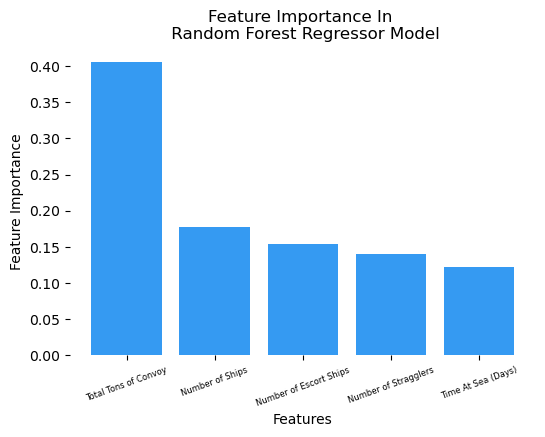

In [39]:
#Plot Feature Importance
df_5 = df_3.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', \
                       'Total Tons of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Overall Sink Percentage', \
                        'Escort Sink Percentage', 'Straggler Sink Percentage']) #Drop all irrelevant features
feat_importances = Ran_Forest_Model.feature_importances_
features = df_5.columns
indices = np.argsort(feat_importances)[::-1]
plt.figure(figsize=(6, 4))
plt.bar(range(X_train.shape[1]), feat_importances[indices], color='#359af2')
plt.title('Feature Importance In \n Random Forest Regressor Model')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.xticks(range(X_train.shape[1]), features[indices], fontsize=6, rotation=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

In [40]:
#Gradient Boosting model
GB_model = GradientBoostingRegressor(random_state=1945)
GB_model.fit(X_train, y_train)
y_predict = GB_model.predict(X_test)
GB_mse = mean_squared_error(y_test, y_predict)
print('Gradient Boosting Regressor Train Score (Mean Accuracy):', GB_model.score(X_train, y_train))
print('Gradient Boosting Regressor Test Score (Mean Accuracy):', GB_model.score(X_test, y_test))
print('Gradient Boosting Regressor Mean Squared Error', GB_mse)

Gradient Boosting Regressor Train Score (R²): 0.8833259404190054
Gradient Boosting Regressor Test Score (R²): -0.6457758668895888
Gradient Boosting Regressor Mean Squared Error 19.590992567553325


In [41]:
train_scores, test_scores = K_Fold(GB_model, X, y, 10, )
print('K_Fold Gradient Boosting Train Score (Mean Accuracy):', np.mean(train_scores))
print('K_Fold Gradient Boosting Test Score (Mean Accuracy):',np.mean(test_scores))

K_Fold Gradient Boosting Train Score (R²): 0.8629370515235028
K_Fold Gradient Boosting Test Score (R²): -0.4860677696147954


Examining the whole data set again and not just cases where at least one ship was sunk:

In [43]:
df_4 = pd.read_csv('SC-OB-HX-Data.csv')
df_4 = df_4.drop(columns=['Unnamed: 0'])
df_4 = df_4[df_4['Arrival/Dispersal Date'] != '0']
df_4['Depart_Date'] = pd.to_datetime(df_4['Depart_Date'])
df_4['Arrival/Dispersal Date'] = pd.to_datetime(df_4['Arrival/Dispersal Date'])
df_4['Time At Sea (Days)'] = (df_4['Arrival/Dispersal Date'] - df_4['Depart_Date']).dt.days
df_4.describe()


,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Overall Sink Percentage,Escort Sink Percentage,Straggler Sink Percentage,Time At Sea (Days)
count,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,8.160000e+02,816.000000,816.000000,816.000000,816.000000,816.000000
mean,52.851716,12.613971,0.479167,0.666667,0.022059,0.131127,2.443570e+05,3684.169118,1.321174,0.161715,7.827819,11.718137
std,26.870767,8.712969,1.556166,1.950722,0.170178,0.481523,1.487340e+05,10620.468503,3.693149,1.280630,25.937052,5.677982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,34.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.421835e+05,0.000000,0.000000,0.000000,0.000000,5.000000
50%,49.000000,12.000000,0.000000,0.000000,0.000000,0.000000,2.083420e+05,0.000000,0.000000,0.000000,0.000000,14.000000
75%,68.000000,19.000000,0.000000,0.000000,0.000000,0.000000,3.103842e+05,0.000000,0.000000,0.000000,0.000000,16.000000
max,191.000000,47.000000,22.000000,20.000000,3.000000,5.000000,1.054593e+06,93502.000000,46.511628,16.666667,100.000000,25.000000


In [44]:
X = df_4.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', \
                       'Total Tons of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Overall Sink Percentage', \
                        'Escort Sink Percentage', 'Straggler Sink Percentage']) #Drop all irrelevant features
y = df_4['Overall Sink Percentage'] #Target for prediction models
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1945) 

In [45]:
#Cross-validation for optimal n_estimators
param_grid = {'n_estimators': [395, 386, 387, 388, 389, 390]}
RF_Model = RandomForestRegressor(random_state=1945)
grid_search = GridSearchCV(estimator=RF_Model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_param = grid_search.best_params_
best_score = grid_search.best_score_
print(best_param)
print('Best Score:', best_score)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'n_estimators': 388}
Best Score: -14.643272615349739


In [46]:
#Random Forest Regressor Model
Ran_Forest_Model = RandomForestRegressor(n_estimators=388, random_state=1945) #n_estimators can be optimized using cross-validation
Ran_Forest_Model.fit(X_train, y_train)
y_predict = Ran_Forest_Model.predict(X_test)
RFR_mse = mean_squared_error(y_test, y_predict)
print('Random Forest Regressor Train Score (R\u00b2):', Ran_Forest_Model.score(X_train, y_train))
print('Random Forest Regressor Test Score (R\u00b2):', Ran_Forest_Model.score(X_test, y_test))
print('Random Forest Regressor Mean Squared Error', RFR_mse)

Random Forest Regressor Train Score (R²): 0.8607234957371288
Random Forest Regressor Test Score (R²): -0.0652198431944675
Random Forest Regressor Mean Squared Error 13.033604184115635


In [47]:
#Gradient Boosting model
GB_model = GradientBoostingRegressor(random_state=1945)
GB_model.fit(X_train, y_train)
y_predict = GB_model.predict(X_test)
GB_mse = mean_squared_error(y_test, y_predict)
print('Random Forest Regressor Train Score (R\u00b2):', GB_model.score(X_train, y_train))
print('Random Forest Regressor Test Score (R\u00b2):', GB_model.score(X_test, y_test))
print('Random Forest Regressor Mean Squared Error', GB_mse)

Random Forest Regressor Train Score (R²): 0.7381172299168672
Random Forest Regressor Test Score (R²): -0.07784115142305459
Random Forest Regressor Mean Squared Error 13.18803346628504


K-Fold Cross Validation for df_4

In [48]:
#Converting X & y to correct format for use in K-Fold Cross-Validation
X = np.array(df_4.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Number of Escorts Sunk', 'Number of Stragglers Sunk', \
                       'Total Tons of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Overall Sink Percentage', \
                        'Escort Sink Percentage', 'Straggler Sink Percentage'])) #Drop all irrelevant features
y = df_4['Overall Sink Percentage'].values #Target for prediction models

In [49]:
train_scores, test_scores = K_Fold(Ran_Forest_Model, X, y, 10, )
print('K_Fold Random Forest Regressor Train Score (R\u00b2):', np.mean(train_scores))
print('K_Fold Random Forest Regressor Test Score (R\u00b2):',np.mean(test_scores))

K_Fold Random Forest Regressor Train Score (R²): 0.8555721017330307
K_Fold Random Forest Regressor Test Score (R²): -0.1763765152167436


In [50]:
train_scores, test_scores = K_Fold(GB_model, X, y, 10, )
print('K_Fold Gradient Boosting Train Score (Mean Accuracy):', np.mean(train_scores))
print('K_Fold RGradient Boosting Test Score (Mean Accuracy):',np.mean(test_scores))

K_Fold Gradient Boosting Train Score (R²): 0.6752076741973634
K_Fold RGradient Boosting Test Score (R²): -0.13251378645078385


Although some models are able to fit well to the training data, none fit the test data properly. All test scores are negative indicating models that remain overfit to the data. From here, new features need to be introduced along with a larger data sample to capture more varaince.

